# Chapter 6 Deep Learning Techniques 

매개변수 갱신
- 신경망 학습의 목적은 손실 함수의 값을 가능한 한 낮추는 매개변수를 찾는 것입니다. (Process of Optimization)
- 현재 책에서는 SGD 확률적 경사 하강법을 주로 사용하고 있습니다. 

SGD
- sgd는 기울어진 방향으로 일정 거리만 나가는 단순한 방법입니다. 
- Learning rate 확습률에 따라서 나아가는 거리를 받아들입니다
- 각 epoch마다 loss를 줄여갑니다 
- 단점
    - 비효율적일때가 많습니다. 
    - 예를 들어 x, y의 기울기가 차이가 많을 경우, 하나의 값에만 의존하여 loss를 줄어가기에 최적의 해를 찾지 못 하는 경우가 있습니다. 
    - 비등방성 (anistrophy), 방향에 따라 성질 기울기가 달라지는 함수
        - 지그재그 방향으로 나가기 때문에 탐색 경로가 비효율 적입니다. 

In [2]:
## SGD 구현 

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr 
    ## params, grad 각 각 매개 변수, 기울기 
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grad[key]
            
## 밑에 코드는 실제로 동작하진 않지만 신경망 작동 원리에 대해 간략하게 나타내고 있습니다. 

# network = TwoLayerNet(...)
# optimizer = SGD()
# for i in rnage(10000):
#     ...
#     x_batch, t_batch = get_mini_batch(...)
#     grads = network.gradient(x_batch, t_batch)
#     params = network.params
#     optimizer.update(params, grads)
#     ...

Momentum
- 운동량, 기울기 방향으로 힘을 받아 물체가 가속된다는 물리 법칙
- 밑에서 v는 속도, nu는 학습률, 미분은 기울기를 나타냅니다. 
    - av는 아무런 힘을 받지 않을때 서서히 하강시키는 역할을 합니다
- 매개변수는 위에 첫 공식으로 갱신이 됩니다
$$ 
V <- {\alpha}v - {\nu}\frac{{\partial}L}{{\partial}W}
$$
$$
W <- W + v
$$
- SGD와 비교시 일정 방향으로 일정하게 가속하기 때문에 지그재그 움직임이 많이 줄어듭니다. 

In [4]:
## Momentum 구현 
import numpy as np 
class SGD:
    def __init__(self, lr=0.01, momentum=0.9):
        self.momentum = momentum
        self.lr = lr 
        self.v = None 
    ## params, grad 각 각 매개 변수, 기울기 
    def update(self, params, grads):
        # 초기엔 속도가 없다 
        if self.v is None: 
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]


AdaGrad
- 신경망에서는 학습률 값이 중요합니다. 이 값이 너무 작으면 학습 시간이 너무 길어지고, 반대로 너무 크면 발산하여 학습이 이루어 지지 않습니다. 
- 학습률 감소를 토해 학습을 진행하면서 학습률을 점차 줄여가는 방법입니다. 
- AdaGrad는 개별 매개변수의 학습률을 적용적으로 조정하면서 학습을 진행합니다.
- h는 기울기 값을 제곱하여 계속 더 해주고 학습률을 조정 해 줍니다. 
$$ 
h <- h + \frac{{\partial}L}{{\partial}W} * \frac{{\partial}L}{{\partial}W}
$$
$$
W <- W  - {\nu}\frac{1}{\sqrt h}\frac{{\partial}L}{{\partial}W}
$$

In [6]:
## AdaGrad 
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr 
        self.h = None 
    
    def update(self, params, grads):
        if self.h is None: 
            self.h = {}
            for key, hal in params.items():
                self.h[key] = np.zeros_like(hal)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            # to aviod zero division, we add small values 
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

Adams 
- Adams는 Momentum과 AdaGrad를 융합한 기법입니다. 
- 효율적으로 매개변수를 탐색하고 하이퍼파라미터의 편향 보정이 진행 됩니다. 

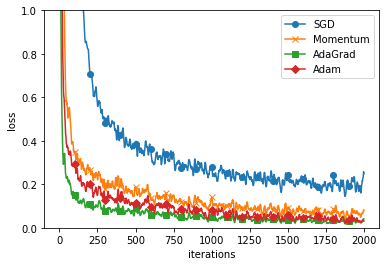

In [8]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        #print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            #print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

가중치의 초깃값 
- 가중치의 초깃값은 신경망 학습에서 중요합니다 
- 초깃값을 0으로 한다면, 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문입니다. 또한 순전파 때도 같은 값이 전달 됩니다. 그러므로 초깃값은 무작위로 설정해야 합니다. 

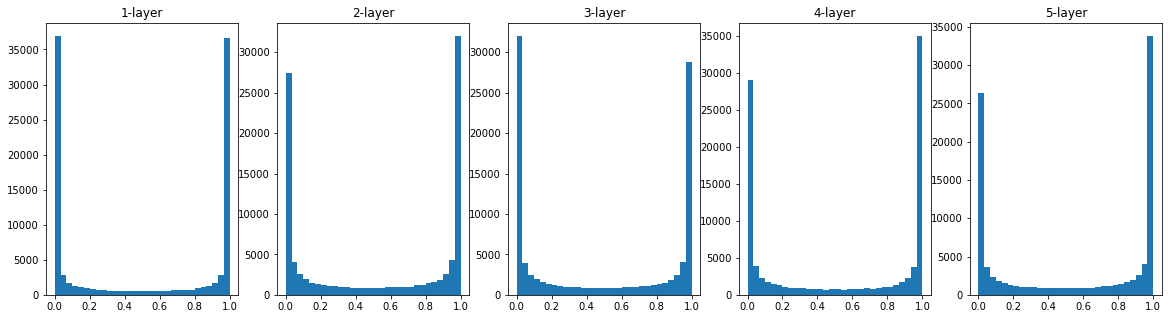

In [15]:
## 은닉층의 활성화값 분포 
import numpy as np 
import matplotlib.pyplot as plt 

def sigmoid(x):
     return 1 / (1 + np.exp(-x))
plt.figure(figsize=(20,5))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5 
activations = {} 

for i in range(hidden_layer_size):
    if i != 0: 
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z 

for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

위에 결과에서 볼 수 있다시미 활성화값들이 0과 1에 분포되어 있습니다. 여기에서 사용한 시그모이드 함수는 출력이 0 또는 1에 가까워지자 미분이 0 또는 1에 가까워 집니다. 
이것이 기울기 소실입니다. 층을 깊게 하면 기울기 소실은 더 큰 문제가 됩니다

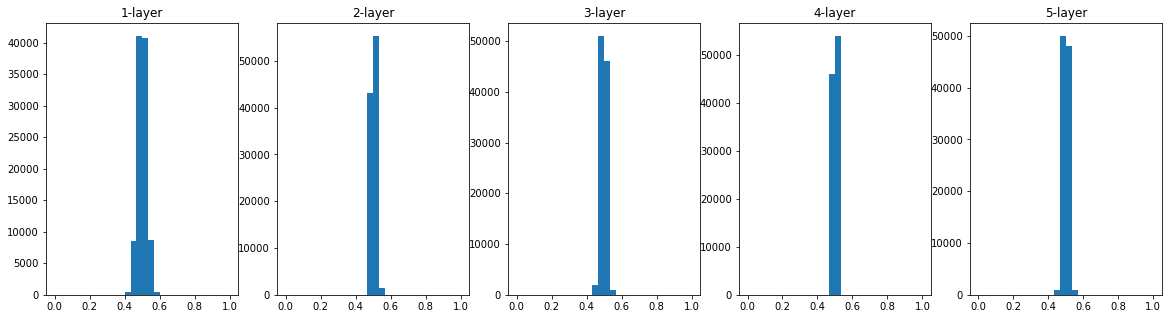

In [18]:
plt.figure(figsize=(20,5))
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5 
activations = {} 

for i in range(hidden_layer_size):
    if i != 0: 
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z 

for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

위에 결과처럼 값이 치우쳐져 있지는 않지만 0.5에 집중되어 있습니다. 다수의 뉴런이 거의 값은 값을 출력하고 있어 뉴런을 여러 개 둔 의미가 없습니다.

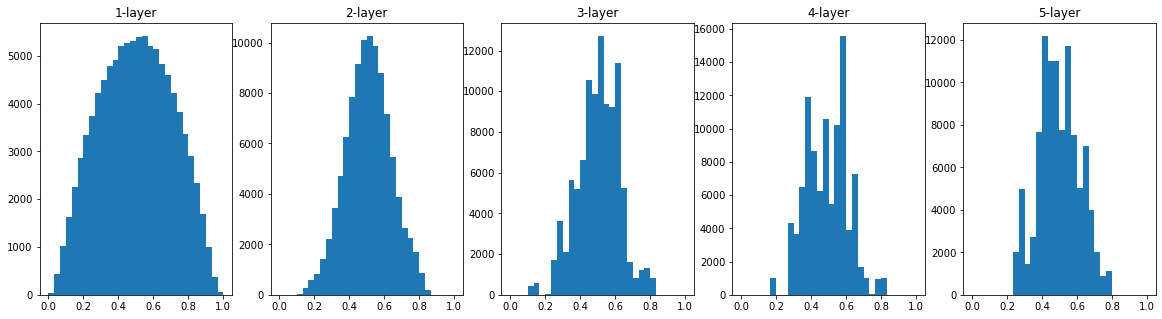

In [20]:
## Xavier 가중치 
plt.figure(figsize=(20,5))
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5 
activations = {} 

for i in range(hidden_layer_size):
    if i != 0: 
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z 

for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

Xavier 초깃값은 각 층의 활성화값들을 광범위하게 본포시킬 목적으로 가중치의 적절한 분포를 찾습니다. 앞 계층의 노드가 N개라면 표준편차가 1/n^-1/2인 분포를 사용합니다. 
Xavier 초깃값은 앞 층에 노드가 많을수록 대상 노드의 초깃값으로 설정하는 가중치가 좁게 퍼집니다. 

ReLU를 사용할 때의 가중치 
- Xavier 함수는 활성화 함수가 선형인 것을 전제로 이끈 결과입니다. Sigmoid와 tanh함수는 좌우 대칭이라 중앙 부근이 선형인 함수라고 볼 수 있습니다. 
- ReLU 사용 시 ReLU에 특화된 초깃값을 이용해야 합니다. 
- He 초깃값 
    - 앞 계층의 노드가 n개일때 표준편차가 (2/n) ^ -1/2인 정규분포를 사용합니다. 
    - ReLU는 음의 영역이 0이라서 더 넓게 분포시키기 위해서입니다. 

ReLU에서 초깃값을 설정을 잘 못 할 경우 

std인 경우 학습이 안되고, xavier를 쓸 경우 값이 값이 한 쪽으로 치우쳐저 있습니다. 
하지만 He 초깃값은 모든 층에서 균일하게 분포가 되어 있습니다. 그러므로 층이 깊어져도 
분포가 균일하게 유지되기에 역전파 때도 적절한 값이 나올 수 있습니다. 

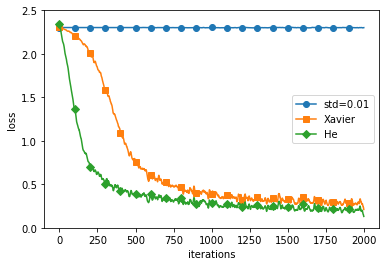

In [31]:
# 학습률 비교 
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        #print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
        #print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

배치 정규화 
- 각 층이 활성화를 적당히 퍼뜨리도록 강제하는 기법이 배치 정규화입니다. 
- 장점
    - 학습 속도 개선/낮은 초깃값 의존도/오버피틍 억제 
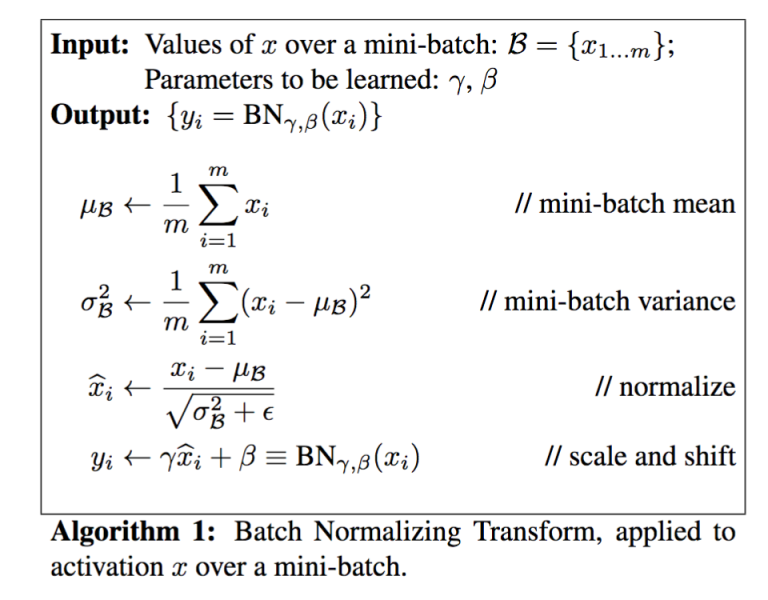   

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

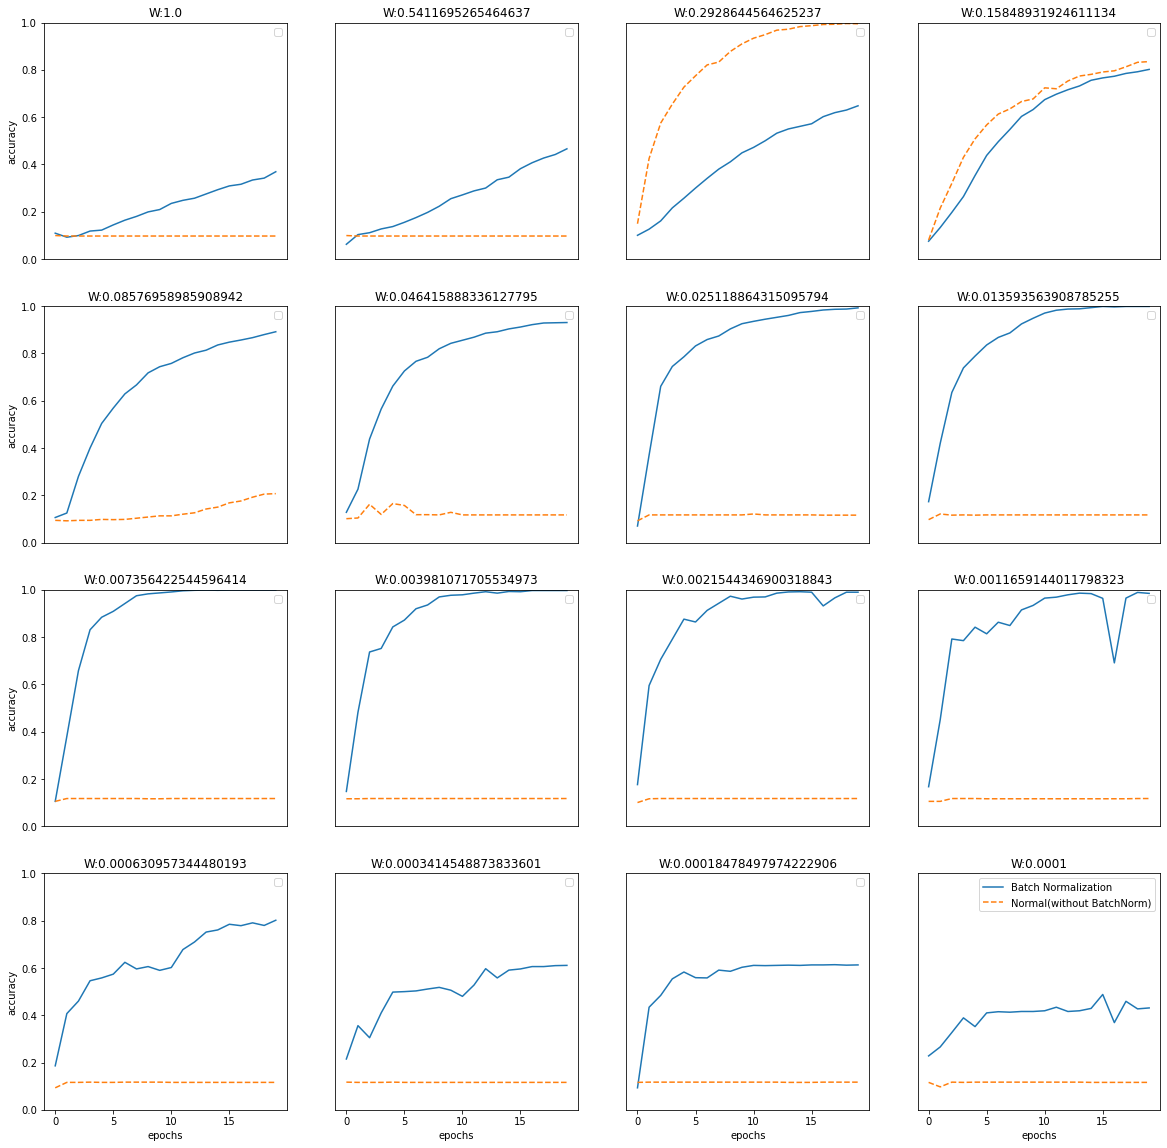

In [38]:
## batch 정규호 효과 
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam
import warnings
warnings.simplefilter("ignore", UserWarning)

#import the_module_that_warns
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
plt.figure(figsize=(20,20))

def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            #print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    #print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend()
    
plt.show()

바른 학습 
- 오버피팅발생 원인
    - 매개변수가 많고 표현력이 높은 모델 
    - 훈련 데이터가 적음 

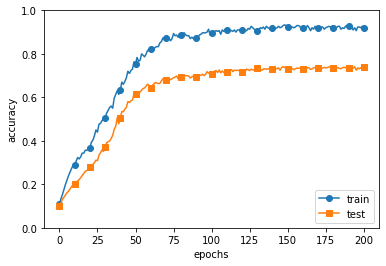

In [42]:
## 오버피팅 구현 
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
#weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        #print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

가중치 감소 
- 오버피팅을 억제 할 수 있는 방법 중 하나는 가중치 감소입니다
- 학습 과정에서 큰 가중치에 대해서는 상응하는 페널티를 보과합니다. 예) L2 노름 

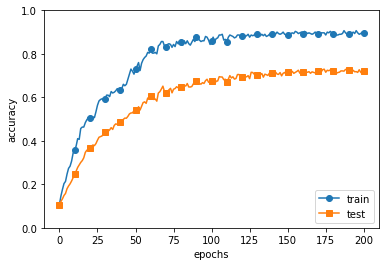

In [43]:
## 오버피팅 구현 
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        #print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

위에 있는 두 그래프에서 보듯이 페널티를 부여해 오버피팅을 낮추었습니다. 

드롭아웃 
- 가중치 감소만으로는 복잡한 신경망 모델에 대응 하기 힘들어 dropout을 씁니다 
- 임의로 뉴런을 삭제하면서 학습하는 방법입니다. 
- 훈련 때 은닉층의 뉴런을 무작위로 골라 삭제합니다. 
- 훈련때는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택하고, 시험 때는 모든 뉴런에 신호를 전달합니다. 
- 단 시험 때는 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력합니다. 

train loss:2.2999947939036636
=== epoch:1, train acc:0.06333333333333334, test acc:0.0714 ===
train loss:2.317466564946076
train loss:2.294863334843092
train loss:2.294517061410514
=== epoch:2, train acc:0.06333333333333334, test acc:0.0722 ===
train loss:2.2962312656010675
train loss:2.2983161500246245
train loss:2.2736745850699656
=== epoch:3, train acc:0.06666666666666667, test acc:0.0732 ===
train loss:2.2802092486990024
train loss:2.31558081394837
train loss:2.3031764104336294
=== epoch:4, train acc:0.06666666666666667, test acc:0.0739 ===
train loss:2.269459082493571
train loss:2.304586584870386
train loss:2.2861582720697093
=== epoch:5, train acc:0.07, test acc:0.0744 ===
train loss:2.290701167891223
train loss:2.297223990013549
train loss:2.2854628331473403
=== epoch:6, train acc:0.07666666666666666, test acc:0.074 ===
train loss:2.306223600598203
train loss:2.310162780681942
train loss:2.2628418086578366
=== epoch:7, train acc:0.07, test acc:0.0775 ===
train loss:2.28181903150

=== epoch:56, train acc:0.21666666666666667, test acc:0.1735 ===
train loss:2.218737301871589
train loss:2.241877026234657
train loss:2.237815834383481
=== epoch:57, train acc:0.22333333333333333, test acc:0.1772 ===
train loss:2.249658574686664
train loss:2.2410561147821384
train loss:2.22573199270913
=== epoch:58, train acc:0.24, test acc:0.1859 ===
train loss:2.191023413541277
train loss:2.188337861669412
train loss:2.207027167763322
=== epoch:59, train acc:0.23666666666666666, test acc:0.1844 ===
train loss:2.2184206021558652
train loss:2.2156036438675795
train loss:2.1981431482475493
=== epoch:60, train acc:0.23333333333333334, test acc:0.1809 ===
train loss:2.2412211485051863
train loss:2.2329683254158974
train loss:2.2114807053387224
=== epoch:61, train acc:0.24333333333333335, test acc:0.1885 ===
train loss:2.188691490552736
train loss:2.220943796203695
train loss:2.1828011352274395
=== epoch:62, train acc:0.24, test acc:0.1907 ===
train loss:2.2055732298365283
train loss:2.194

=== epoch:112, train acc:0.39666666666666667, test acc:0.2831 ===
train loss:2.0262163084122182
train loss:2.1078576460751433
train loss:2.1206476756364894
=== epoch:113, train acc:0.4033333333333333, test acc:0.2858 ===
train loss:2.033413151947074
train loss:2.0803099828250966
train loss:2.0702495585608682
=== epoch:114, train acc:0.4066666666666667, test acc:0.2911 ===
train loss:2.0649701584967493
train loss:1.9965918891043584
train loss:2.0729042060945573
=== epoch:115, train acc:0.41, test acc:0.2936 ===
train loss:2.077876762339551
train loss:2.020990988592576
train loss:2.0363014279788034
=== epoch:116, train acc:0.41, test acc:0.2949 ===
train loss:1.9609881539231966
train loss:2.0382351502693936
train loss:2.073506601441538
=== epoch:117, train acc:0.4033333333333333, test acc:0.2891 ===
train loss:2.0305485019295686
train loss:2.04586803526624
train loss:2.0474200995642446
=== epoch:118, train acc:0.4166666666666667, test acc:0.2951 ===
train loss:2.0399926634184937
train lo

=== epoch:167, train acc:0.5266666666666666, test acc:0.4093 ===
train loss:1.8005893765055176
train loss:1.7950981735539944
train loss:1.863838712631749
=== epoch:168, train acc:0.53, test acc:0.4125 ===
train loss:1.7492796325235533
train loss:1.7811396633963346
train loss:1.7656254401434301
=== epoch:169, train acc:0.5333333333333333, test acc:0.4173 ===
train loss:1.6447863151356952
train loss:1.72318915965559
train loss:1.7977353856208556
=== epoch:170, train acc:0.5366666666666666, test acc:0.4172 ===
train loss:1.7860050085252341
train loss:1.808638125263232
train loss:1.7340586957581292
=== epoch:171, train acc:0.5366666666666666, test acc:0.4157 ===
train loss:1.8490507763428528
train loss:1.7343921601116128
train loss:1.745113493373513
=== epoch:172, train acc:0.5366666666666666, test acc:0.4181 ===
train loss:1.8017789289518473
train loss:1.7465572716809914
train loss:1.7171079336281097
=== epoch:173, train acc:0.5366666666666666, test acc:0.4176 ===
train loss:1.82560107179

=== epoch:223, train acc:0.6066666666666667, test acc:0.4945 ===
train loss:1.3692107892807694
train loss:1.4622942547364832
train loss:1.220758383123475
=== epoch:224, train acc:0.6033333333333334, test acc:0.4944 ===
train loss:1.4775215750107376
train loss:1.6200366773681203
train loss:1.5302489706009426
=== epoch:225, train acc:0.6, test acc:0.4981 ===
train loss:1.4139445856330142
train loss:1.5050331401259351
train loss:1.4958926375108645
=== epoch:226, train acc:0.6066666666666667, test acc:0.5026 ===
train loss:1.385158766785612
train loss:1.5158996009061116
train loss:1.4296051714898388
=== epoch:227, train acc:0.6066666666666667, test acc:0.501 ===
train loss:1.3673641195519692
train loss:1.428936875373625
train loss:1.5599454181071
=== epoch:228, train acc:0.6066666666666667, test acc:0.5041 ===
train loss:1.5076818785730246
train loss:1.4470387451293427
train loss:1.3499500200841288
=== epoch:229, train acc:0.62, test acc:0.5038 ===
train loss:1.5220144349092144
train loss:

=== epoch:280, train acc:0.67, test acc:0.5698 ===
train loss:1.2459806652708048
train loss:1.2148536605155704
train loss:1.223747661020787
=== epoch:281, train acc:0.6733333333333333, test acc:0.5713 ===
train loss:1.22651634110413
train loss:1.179627324075843
train loss:1.129135912806186
=== epoch:282, train acc:0.6733333333333333, test acc:0.5699 ===
train loss:1.1851188034655273
train loss:1.0166238495323219
train loss:1.1045695139266218
=== epoch:283, train acc:0.67, test acc:0.5696 ===
train loss:1.226010490669183
train loss:1.0495821416797932
train loss:1.1901491927041183
=== epoch:284, train acc:0.67, test acc:0.5695 ===
train loss:1.2170783654463286
train loss:1.195275102797485
train loss:1.1577589613251964
=== epoch:285, train acc:0.6733333333333333, test acc:0.571 ===
train loss:1.150163504006429
train loss:1.0622405180391243
train loss:1.1174654373999884
=== epoch:286, train acc:0.6733333333333333, test acc:0.5713 ===
train loss:1.2010399974256827
train loss:1.0469734590827

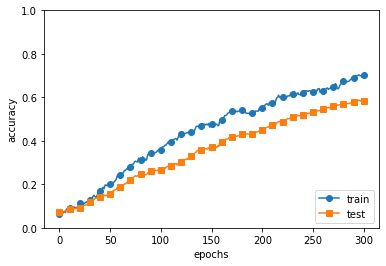

In [45]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


Finding HyperParameter 
- 검증 데이터를 통해 하이퍼파라미터를 구한다 
- 하이퍼파라미터 최작화 시 하이퍼파라미터의 존재 범위를 줄인다 
- 빠른 학습을 위한 에폭을 작게 하여 1회 평가에 걸리는 시간을 단축한다 

val acc:0.11 | lr:2.8145126232412502e-05, weight decay:4.768973370815553e-08
val acc:0.1 | lr:0.0002502193402419925, weight decay:8.248980982775417e-07
val acc:0.07 | lr:8.180432056815662e-05, weight decay:3.354567116396283e-05
val acc:0.05 | lr:1.161017626918108e-05, weight decay:3.987603867929059e-08
val acc:0.08 | lr:9.238668975216985e-06, weight decay:5.024042506532529e-06
val acc:0.11 | lr:0.00022223009884278215, weight decay:2.238136314468116e-08
val acc:0.09 | lr:0.0004985649609071138, weight decay:6.20213693408002e-07
val acc:0.14 | lr:5.998793461548319e-05, weight decay:3.616207954385889e-06
val acc:0.15 | lr:0.0001169916388976431, weight decay:1.365410867728171e-07
val acc:0.37 | lr:0.00172339092975911, weight decay:8.198284320199618e-07
val acc:0.08 | lr:2.278836988472803e-05, weight decay:4.760545870848915e-05
val acc:0.08 | lr:0.0007390429081220547, weight decay:8.081379419063572e-06
val acc:0.46 | lr:0.0025323637315736477, weight decay:2.841291408669609e-06
val acc:0.08 |

Best-9(val acc:0.54) | lr:0.003426518180020665, weight decay:2.894793769113019e-08
Best-10(val acc:0.51) | lr:0.004014027062508957, weight decay:2.389224412409491e-05
Best-11(val acc:0.49) | lr:0.0031093872310395316, weight decay:9.540500706268296e-08
Best-12(val acc:0.46) | lr:0.0025323637315736477, weight decay:2.841291408669609e-06
Best-13(val acc:0.44) | lr:0.0039366569833934, weight decay:3.7200446544527784e-05
Best-14(val acc:0.37) | lr:0.00172339092975911, weight decay:8.198284320199618e-07
Best-15(val acc:0.33) | lr:0.0019250224251048833, weight decay:7.562476272527578e-05
Best-16(val acc:0.32) | lr:0.002168490231859438, weight decay:5.138778516533407e-06
Best-17(val acc:0.3) | lr:0.0016876321810681068, weight decay:8.324607204911077e-07
Best-18(val acc:0.29) | lr:0.00020680594034665865, weight decay:1.003253151141912e-07
Best-19(val acc:0.28) | lr:0.0013508309607650623, weight decay:6.364900371535341e-05
Best-20(val acc:0.27) | lr:0.0011879700971538182, weight decay:9.16419659

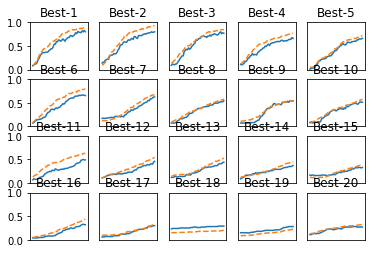

In [46]:
## hyperparamter 구현 
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

Summary 
- 매개변수 갱신 방법에는 확률적 경사 하강법(SGD) 외에도 모멘텀, AdaGrad, Adam 등이 있다.
- 가중치 초깃값을 정하는 방법은 올바른 학습을 하는 데 매우 중요하다.
- 가중치의 초깃값으로는 ‘Xavier 초깃값’과 ‘He 초깃값’이 효과적이다.
- 배치 정규화를 이용하면 학습을 빠르게 진행할 수 있으며, 초깃값에 영향을 덜 받게 된다.
- 오버피팅을 억제하는 정규화 기술로는 가중치 감소와 드롭아웃이 있다.
- 하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 범위를 점차 좁히면서 하는 것이 효과적이다.